In [1]:
import sys
import os
sys.path.append('C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\python_functions\\jl_nlp_pkg')
sys.path.append('C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\python_functions\\jl_model_explain_pkg')
import nlpbasic.textClean as textClean
import nlpbasic.docVectors as DocVector
import nlpbasic.dataExploration as DataExploration
import nlpbasic.lda as lda
import nlpbasic.tfidf as tfidf

import model_explain.plot as meplot
import model_explain.shap as meshap

from numpy import array,asarray,zeros
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,Flatten,Embedding
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import re
pd.set_option('display.max_colwidth', None)
root_path = 'C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\NLP_data'

# Load Data and Basic Exploration

In [2]:
djia_news = pd.read_csv(os.path.join(root_path, "djia_news.csv"))
nasdaq = pd.read_csv(os.path.join(root_path, "nasdaq.csv"))
class_names = ['negative', 'positive','neutral'] #0:neg 1:pos 2:neu

In [3]:
djia_news.head(3)

,Label,Ticker,Headline
0,0,MMM,Employer who stole nearly $3M in wages from 157 workers fined $500
1,1,MMM,Huge new Facebook data leak exposed intimate details of 3m users
2,0,MMM,A campaign has accelerated to turn a disused railway line in Yorkshire into England’s longest cycle tunnel – instead of using £3m of public money to close it for ever. Campaigners say they could enhance West Yorkshire’s health and economy by converting an old railway line.


In [4]:
nasdaq.head(3)

,Label,Ticker,Headline
0,0,A,@TotesTravel : Airline shares tumble as New York imposes quarantine Florida cases spike - An American Airlines Group Inc. plane prepares for landing at LaGuardia Airport (LGA) in New York U.S. on Tuesday April 18... #TravelNewsInsights - https://t.co/6fnJSf3bRh
1,1,A,@TotesTravel : American United call off Hong Kong flights after crew testing rules - An American Airlines Group Inc. Boeing Co. 777-300ER aircraft sits at Hong Kong International Airport in Hong Kong China. Brent... #TravelNewsInsights - https://t.co/mM34IZz6lM
2,0,A,@TotesTravel : U.S. airline stocks hit highest prices since June on travel uptick stimulus hopes - A JetBlue Airways Corp. plane taxis next to American Airlines Group Inc. Delta Air Lines Inc. and Alaska Airlines Inc. aircraft... #TravelNewsInsights - https://t.co/bwxoJDizzN


In [10]:
print('djia_news label',djia_news.Label.value_counts())
print('djia_news data', len(djia_news))
print('djia_news ticker', len(djia_news.Ticker.unique()))
print('----------------')
print('djia_news sample')
print(djia_news.Headline[0])

djia_news label 0    1430
1     936
2      15
Name: Label, dtype: int64
djia_news data 2381
djia_news ticker 29
----------------
djia_news sample
Employer who stole nearly $3M in wages from 157 workers fined $500


In [11]:
print('nasdaq label',nasdaq.Label.value_counts())
print('nasdaq data', len(nasdaq))
print('nasdaq ticker', len(nasdaq.Ticker.unique()))
print('----------------')
print('nasdaq sample')
print(nasdaq.Headline[0])

nasdaq label 0    8565
1    4300
2     316
Name: Label, dtype: int64
nasdaq data 13181
nasdaq ticker 546
----------------
nasdaq sample
@TotesTravel : Airline shares tumble as New York imposes quarantine Florida cases spike - An American Airlines Group Inc. plane prepares for landing at LaGuardia Airport (LGA) in New York U.S. on Tuesday April 18... #TravelNewsInsights - https://t.co/6fnJSf3bRh


# NLP Exploration

In [16]:
djia_tokens = textClean.pipeline(djia_news['Headline'].to_list(), multi_gram = [1], lower_case=True, deacc=False, 
                                 encoding='utf8', errors='strict', stem_lemma = 'lemma', tag_drop = ['V'], nltk_stop=True, 
                                 stop_word_list=[], remove_pattern = [], check_numbers=True, word_length=2, 
                                 remove_consecutives=True)

In [26]:
nasdaq_tokens = textClean.pipeline(nasdaq['Headline'].to_list(), multi_gram = [1], lower_case=True, deacc=False, 
                                 encoding='utf8', errors='strict', stem_lemma = 'lemma', tag_drop = ['V'], nltk_stop=True, 
                                 stop_word_list=[], remove_pattern = ['http:','#', '@'], check_numbers=True, word_length=2, 
                                 remove_consecutives=True)

In [23]:
top_10_freq_words = [i[0] for i in DataExploration.get_topn_freq_bow(djia_tokens, topn = 10)]
print('top 10 frequent words', top_10_freq_words)
top30tfidf = tfidf.get_top_n_tfidf_bow(djia_tokens, top_n_tokens = 30)
print('top 30 tfidf', top30tfidf)
no_topics = 10
lda_allbow, bow_corpus, dictionary = lda.fit_lda(djia_tokens, num_topics = no_topics)
lda.lda_topics(lda_allbow)

top 10 frequent words ['apple', 'company', 'amp', 'microsoft', 'american', 'billion', 'home', 'visa', 'china', 'chevron']
top 30 tfidf ['visa', 'caterpillar', 'salesforce', 'world', 'italy', 'dow', 'low', 'agreement', 'cancer', 'mask', 'boeing', 'thermostat', 'goldman', 'nike', 'ibm', 'india', 'dead', 'disney', 'owner', 'microsoft', 'security', 'mcdonalds', 'company', 'crash', 'walmart', 'walgreens', 'cloud', 'online', 'de', 'office']


,Topics,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10
0,1,american,express,ibm,home,market,company,mcdonalds,billion,technology,employee
1,2,dow,point,china,salesforce,million,walgreens,morgan,caterpillar,merck,chase
2,3,johnson,court,boris,chevron,amp,country,procter,gamble,visa,brexit
3,4,salesforce,chevron,apple,nike,home,billion,depot,american,intel,express
4,5,disney,nike,goldman,russian,sachs,world,coca,walmart,cola,company
5,6,goldman,apple,caterpillar,sachs,bank,new,american,merck,global,report
6,7,walmart,home,depot,american,microsoft,express,worker,company,ibm,profit
7,8,microsoft,johnson,boris,visa,trump,caterpillar,worker,new,uk,nike
8,9,coca,cola,traveler,ibm,inc,intel,water,chinese,government,china
9,10,trump,intel,company,amp,apple,china,chevron,disney,dow,system


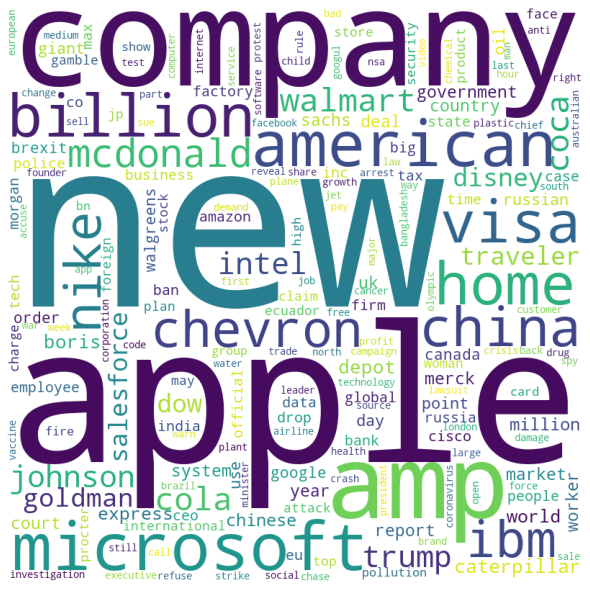

In [20]:
DataExploration.generate_word_cloud(djia_tokens)

In [27]:
top_10_freq_words = [i[0] for i in DataExploration.get_topn_freq_bow(nasdaq_tokens, topn = 10)]
print('top 10 frequent words', top_10_freq_words)
top30tfidf = tfidf.get_top_n_tfidf_bow(nasdaq_tokens, top_n_tokens = 30)
print('top 30 tfidf', top30tfidf)
no_topics = 10
lda_allbow, bow_corpus, dictionary = lda.fit_lda(nasdaq_tokens, num_topics = no_topics)
lda.lda_topics(lda_allbow)

top 10 frequent words ['inc', 'new', 'first', 'amp', 'year', 'world', 'company', 'china', 'news', 'bank']
top 30 tfidf ['moderna', 'dropbox', 'chair', 'elite', 'power', 'indian', 'chappelle', 'team', 'intuit', 'dutch', 'due', 'ai', 'download', 'asia', 'attack', 'domo', 'afya', 'lady', 'outlet', 'opera', 'upwork', 'loss', 'okta', 'de', 'stephen', 'ptc', 'dave', 'reddit', 'roku', 'cadiz']


,Topics,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10
0,1,year,china,verisign,russian,street,ericsson,could,energy,hacker,global
1,2,new,view,amp,state,china,world,bank,education,nasa,job
2,3,view,zynga,country,googul,china,group,inc,state,american,power
3,4,oil,extraction,world,gas,new,climate,report,firm,change,energy
4,5,news,government,woodward,bob,corporation,facebook,chinese,google,amp,company
5,6,power,new,company,solar,energy,market,state,trump,covid,first
6,7,year,view,old,vaccine,russian,way,coronavirus,washington,federal,government
7,8,energy,oil,world,nuclear,china,million,clean,saudi,power,de
8,9,gold,stock,new,first,big,move,korea,bank,tripadvisor,kong
9,10,xp,window,trump,federal,washington,amp,view,judge,donald,inc


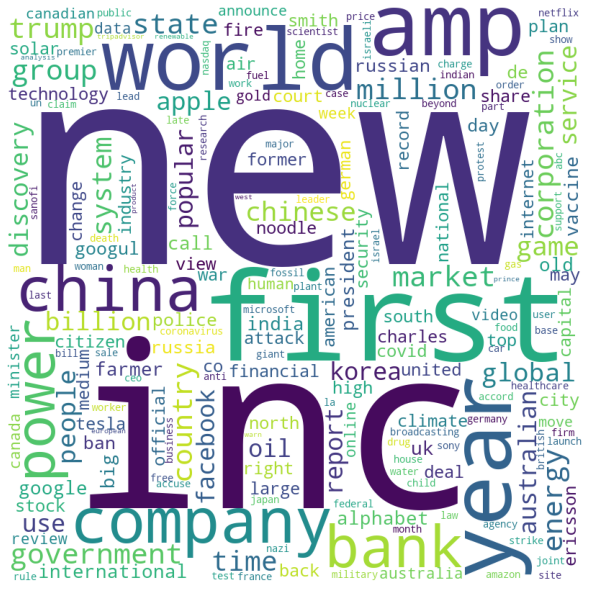

In [28]:
DataExploration.generate_word_cloud(nasdaq_tokens)

# Word Embedding + RNN

In [3]:
nasdaq['tokens'] = textClean.pipeline(nasdaq['Headline'].to_list(), multi_gram = [1], lower_case=True, deacc=False, 
                                 encoding='utf8', errors='strict', stem_lemma = 'lemma', tag_drop = ['V'], nltk_stop=True, 
                                 stop_word_list=[], remove_pattern = ['http:','#', '@'], check_numbers=True, word_length=2, 
                                 remove_consecutives=True)

In [30]:
nasdaq.head(3)

,Label,Ticker,Headline,tokens
0,0,A,@TotesTravel : Airline shares tumble as New York imposes quarantine Florida cases spike - An American Airlines Group Inc. plane prepares for landing at LaGuardia Airport (LGA) in New York U.S. on Tuesday April 18... #TravelNewsInsights - https://t.co/6fnJSf3bRh,"[airline, share, new, york, imposes, florida, case, american, airline, group, plane, prepares, land, laguardia, airport, lga, new, york, tuesday, april, http, co, fnjsf, brh]"
1,1,A,@TotesTravel : American United call off Hong Kong flights after crew testing rules - An American Airlines Group Inc. Boeing Co. 777-300ER aircraft sits at Hong Kong International Airport in Hong Kong China. Brent... #TravelNewsInsights - https://t.co/mM34IZz6lM,"[american, call, hong, kong, flight, crew, test, rule, american, airline, group, co, er, aircraft, sits, hong, kong, international, airport, hong, kong, china, brent, http, co, mm, izz, lm]"
2,0,A,@TotesTravel : U.S. airline stocks hit highest prices since June on travel uptick stimulus hopes - A JetBlue Airways Corp. plane taxis next to American Airlines Group Inc. Delta Air Lines Inc. and Alaska Airlines Inc. aircraft... #TravelNewsInsights - https://t.co/bwxoJDizzN,"[airline, stock, high, price, since, june, travel, uptick, stimulus, jetblue, airway, corp, plane, taxi, next, american, airline, group, delta, air, line, inc, alaska, airline, inc, aircraft, http, co, bwxojdizzn]"


In [4]:
train_index, test_index= train_test_split(nasdaq.index , test_size = 0.33, random_state = 42)
X_train = nasdaq[nasdaq.index.isin(train_index)][['Headline']]
X_test = nasdaq[nasdaq.index.isin(test_index)][['Headline']]
y_train = pd.get_dummies(nasdaq[nasdaq.index.isin(train_index)]['Label']).values
y_test = pd.get_dummies(nasdaq[nasdaq.index.isin(test_index)]['Label']).values
X_train = [i for i in X_train.Headline]
X_test = [i for i in X_test.Headline]



In [6]:
nasdaq['len'] = nasdaq.Headline.apply(lambda x: len(x))

In [7]:
max_length = int(nasdaq.len.quantile(0.99))
max_length

296

In [8]:
t = Tokenizer()
t.fit_on_texts(X_train)

vocab_size = len(t.word_index) + 1
encoded_docs = t.texts_to_sequences(X_train)
padded_docs = pad_sequences(encoded_docs, maxlen = max_length, padding = 'post')
print('Encoding:\n', encoded_docs[0])
print('\nText:\n', list(X_train)[0])
print('\nWord Indices:\n', [(t.index_word[i], i) for i in encoded_docs[0]])
encoded_test_doc = t.texts_to_sequences(X_test)
padded_test_docs = pad_sequences(encoded_test_doc, maxlen = max_length, padding = 'post')

# load the whole embedding into memory
embeddings_index = dict()
# download glove word embedding first and then load it with the following code
f = open('C:/ProgramData/Anaconda3/append_file/glove/glove.6B.100d.txt', encoding = 'utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype = 'float32')
    embeddings_index[word] = coefs
f.close
print('loaded %s word vectors.' % len(embeddings_index))

# Initialize a matrix with zeros having dimensions equivalent to vocab size and 100
embedding_matrix = zeros((vocab_size, 100))
for word, idx_word in t.word_index.items():
    word_vector = embeddings_index.get(word)
    if word_vector is not None:
        embedding_matrix[idx_word] = word_vector
print('word:', t.index_word[1])
print('Embedding:\n', embedding_matrix[1])
print('length of embedding matrix is:', len(embedding_matrix))
print('vocabulary size is %s.' % vocab_size)

Encoding:
 [337, 170, 121, 282, 122, 338, 378, 2274, 20, 1949, 1521, 498, 27, 170, 597, 53, 18, 2449, 108, 7563, 7564, 573, 7565, 19, 338, 378, 74, 1522, 4, 338, 378, 37, 4854, 659, 111, 79, 108, 7566]

Text:
 @TotesTravel : American United call off Hong Kong flights after crew testing rules - An American Airlines Group Inc. Boeing Co. 777-300ER aircraft sits at Hong Kong International Airport in Hong Kong China. Brent... #TravelNewsInsights - https://t.co/mM34IZz6lM

Word Indices:
 [('totestravel', 337), ('american', 170), ('united', 121), ('call', 282), ('off', 122), ('hong', 338), ('kong', 378), ('flights', 2274), ('after', 20), ('crew', 1949), ('testing', 1521), ('rules', 498), ('an', 27), ('american', 170), ('airlines', 597), ('group', 53), ('inc', 18), ('boeing', 2449), ('co', 108), ('777', 7563), ('300er', 7564), ('aircraft', 573), ('sits', 7565), ('at', 19), ('hong', 338), ('kong', 378), ('international', 74), ('airport', 1522), ('in', 4), ('hong', 338), ('kong', 378), ('china'

In [9]:
model = Sequential(
    [
        Embedding(vocab_size, 100, weights = [embedding_matrix], input_length = max_length, trainable = False),
        Flatten(),
        Dense(100, activation="relu", name="layer1"),
        Dense(3, activation = 'softmax', name="layer2")
        
    ]
)
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 296, 100)          1949800   
_________________________________________________________________
flatten (Flatten)            (None, 29600)             0         
_________________________________________________________________
layer1 (Dense)               (None, 100)               2960100   
_________________________________________________________________
layer2 (Dense)               (None, 3)                 303       
Total params: 4,910,203
Trainable params: 2,960,403
Non-trainable params: 1,949,800
_________________________________________________________________
None


In [12]:
# fit the model
history = model.fit(padded_docs, 
                    y_train, 
                    epochs = 10, 
                    verbose = 1, 
                    batch_size = 32, 
                    validation_data = (padded_test_docs, y_test)
                   )

Epoch 1/10
276/276 [==============================] - 5s 20ms/step - loss: 0.1170 - acc: 0.9494 - val_loss: 1.2345 - val_acc: 0.6876
Epoch 2/10
276/276 [==============================] - 5s 19ms/step - loss: 0.1172 - acc: 0.9478 - val_loss: 1.1787 - val_acc: 0.6784
Epoch 3/10
276/276 [==============================] - 5s 20ms/step - loss: 0.1187 - acc: 0.9471 - val_loss: 1.1937 - val_acc: 0.6825
Epoch 4/10
276/276 [==============================] - 5s 19ms/step - loss: 0.1184 - acc: 0.9478 - val_loss: 1.1776 - val_acc: 0.6823
Epoch 5/10
276/276 [==============================] - 5s 19ms/step - loss: 0.1061 - acc: 0.9494 - val_loss: 1.1875 - val_acc: 0.6821
Epoch 6/10
276/276 [==============================] - 5s 19ms/step - loss: 0.1008 - acc: 0.9518 - val_loss: 1.2081 - val_acc: 0.6860
Epoch 7/10
276/276 [==============================] - 5s 19ms/step - loss: 0.1030 - acc: 0.9510 - val_loss: 1.1863 - val_acc: 0.6830
Epoch 8/10
276/276 [==============================] - 5s 19ms/step - 

In [13]:
target_map = {'neg':0,'pos':1,'neu':2}
predsTest = pd.DataFrame(model.predict(padded_test_docs), columns = ['neg','pos','neu'])
predsTest['pred'] = predsTest.idxmax(axis = 1)
predsTest['pred_convert'] = predsTest['pred'].apply(lambda x: target_map[x])

Confusion Matrix: Positive is class 1 and Negative is class 0
[[2211  585   11]
 [ 736  696    6]
 [  68   13   24]]


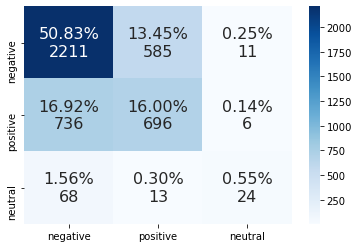

In [14]:
roundedPredsTest = predsTest.pred_convert
print('Confusion Matrix: Positive is class 1 and Negative is class 0')
cf_matrix = confusion_matrix(nasdaq[nasdaq.index.isin(test_index)]['Label'], roundedPredsTest, labels = [0,1,2])
print(cf_matrix)
meplot.cf_matrix_heatmap(cf_matrix, class_names)

In [17]:
nasdaq[nasdaq.index.isin(test_index)]['Label'].value_counts()

0    2807
1    1438
2     105
Name: Label, dtype: int64

In [70]:
print(classification_report(nasdaq[nasdaq.index.isin(test_index)]['Label'],roundedPredsTest))

              precision    recall  f1-score   support

           0       0.73      0.80      0.77      2807
           1       0.55      0.47      0.51      1438
           2       0.57      0.23      0.33       105

    accuracy                           0.68      4350
   macro avg       0.62      0.50      0.53      4350
weighted avg       0.67      0.68      0.67      4350

